In [1]:
import ee
import geemap
import geeopca

In [2]:
ee.Initialize()

In [3]:

aoi = ee.Geometry.Polygon(
    [
        [-77.4467, 44.1024],
        [-77.4467, 44.2352],
        [-77.2686, 44.2352],
        [-77.2686, 44.1024],
        [-77.4467, 44.1024],
    ]
)

SYSTEM_PREFIX = "COPERNICUS/S2_HARMONIZED"
DATES = [(f'{year}-04-01', f'{year}-10-31') for year in range(2017, 2024)]

In [4]:
dataset = geeopca.EarthEngineDataset(SYSTEM_PREFIX, aoi=aoi, dates=DATES)
dataset = dataset.filter_out_clouds("CLOUDY_PIXEL_PERCENTAGE").add_system_prefix()

In [5]:
gdf = geeopca.convert_2_dataframe(dataset)
gdf['sysid'] = gdf['sysid'].apply(lambda row: row[2:])

In [6]:
# date time processing
gdf = geeopca.process_date_time(gdf)


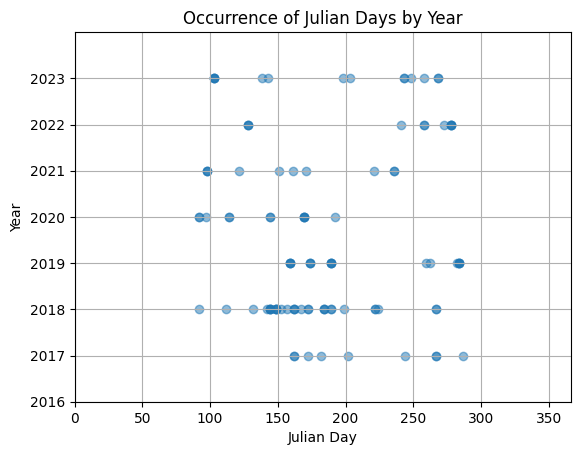

In [7]:
figure = geeopca.date_time_scatter_plot(gdf, None)
